In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
import tensorflow as tf
from PIL import Image
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Add, Conv2D, Activation, Conv2DTranspose, BatchNormalization, concatenate
from keras_contrib.layers.normalization import InstanceNormalization
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
import time
import keras.backend as K

# Reshape Images

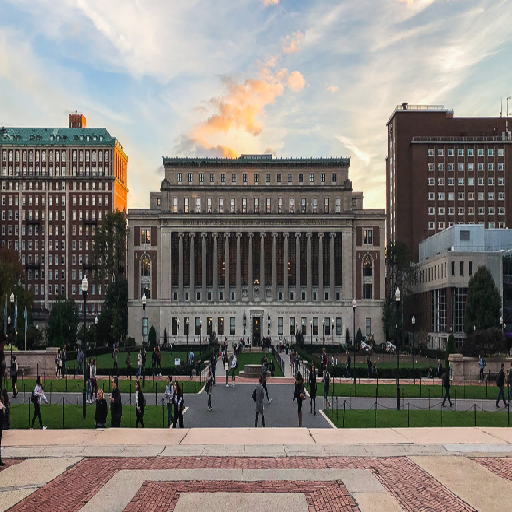

In [3]:
height = 512
width  = 512

content_image_path = 'columbia.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

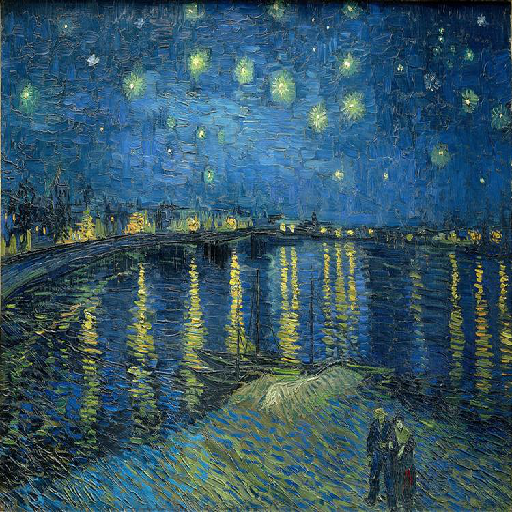

In [4]:
style_image_path = 'starry_night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [5]:
content_array = np.asarray(content_image, dtype='float32')
style_array   = np.asarray(style_image, dtype='float32')
print(content_array.shape)
print(style_array.shape)

(512, 512, 3)
(512, 512, 3)


In [6]:
content_array = np.expand_dims(content_array, axis=0)
style_array   = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


# Image Transform Network

In [0]:
ITN_inputs = Input(shape=(512,512,3), dtype='float32', name="ITN_inputs")

## 1. Encoder Block

In [0]:
x = Conv2D(filters=32, kernel_size=(9,9), strides=1, padding="same")(ITN_inputs)
x = InstanceNormalization(axis=1,center=False, scale=False)(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same")(x)
x = InstanceNormalization(axis=1,center=False, scale=False)(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same")(x)
x = InstanceNormalization(axis=1,center=False, scale=False)(x)
x1 = Activation('relu')(x)

## 2. Residual Block

In [0]:
x1_shortcut = x1
x1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")(x1)
x1 = InstanceNormalization(axis=1, center=False, scale=False)(x1)
x1 = Activation('relu')(x1)
x1 = Add()([x1,x1_shortcut])

x1_shortcut = x1
x1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")(x1)
x1 = InstanceNormalization(axis=1, center=False, scale=False)(x1)
x1 = Activation('relu')(x1)
x1 = Add()([x1,x1_shortcut])

x1_shortcut = x1
x1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")(x1)
x1 = InstanceNormalization(axis=1, center=False, scale=False)(x1)
x1 = Activation('relu')(x1)
x1 = Add()([x1,x1_shortcut])

x1_shortcut = x1
x1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")(x1)
x1 = InstanceNormalization(axis=1, center=False, scale=False)(x1)
x1 = Activation('relu')(x1)
x1 = Add()([x1,x1_shortcut])

x1_shortcut = x1
x1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")(x1)
x1 = InstanceNormalization(axis=1, center=False, scale=False)(x1)
x1 = Activation('relu')(x1)
x2 = Add()([x1,x1_shortcut])

## 3. Decoder Block

In [0]:
x2 = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same")(x2)
x2 = InstanceNormalization(axis=1, center=False, scale=False)(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same")(x2)
x2 = InstanceNormalization(axis=1, center=False, scale=False)(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding="same")(x2)
x2 = InstanceNormalization(axis=1, center=False, scale=False)(x2)
ITN_output = Activation('relu')(x2)

In [0]:
model1 = Model(inputs=ITN_inputs, outputs=ITN_output)   #transform net 1

# VGG16

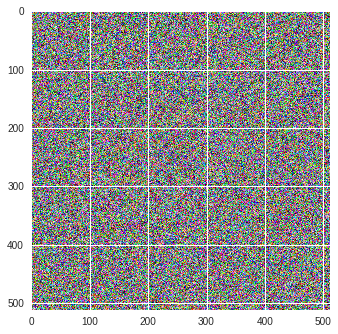

In [16]:
content_img = tf.placeholder(dtype='float32', shape=[1,width,height,3], name='content_image')
style_img =   tf.placeholder(dtype='float32', shape=[1,width,height,3], name='style_image')

combination_img = (np.random.uniform(0, 1, (1, height, width, 3)))*255.
plt.imshow(np.clip(combination_img.reshape((width, height, 3)), 0, 255).astype('uint8'), interpolation='nearest')
plt.show()
combination_img = tf.Variable(combination_img, dtype='float32', name='combination_image')

input_tensor = tf.concat([content_img, style_img, combination_img], axis=0, name='input_tensor')

In [0]:
model2 = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
model2.trainable = False
layers = dict([(layer.name, layer.output) for layer in model2.layers])

In [0]:
def content_loss(content_f, combination_f):
  diff = tf.subtract(combination_f, content_f)
  content_ls = tf.reduce_sum(tf.square(diff))
  return content_ls

In [56]:
content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_features = layer_features[1, :, :, :]
combination_features = layer_features[2, :, :, :]
loss1 = content_loss(content_features, combination_features)
loss1

<tf.Tensor 'Sum_3:0' shape=() dtype=float32>

In [0]:
grads1=K.gradients(loss1, combination_img)

In [79]:
content_output=model1.output
loss2 = tf.losses.mean_squared_error(combination_img,content_output)
loss2

<tf.Tensor 'mean_squared_error_5/value:0' shape=() dtype=float32>

In [0]:
grads2=K.gradients(loss2,model1.weights)

In [0]:
grads=tf.multiply(grads1,grads[0])

In [69]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
  
  sess.run(init_op)

  for i in range(100):
    start_time = time.time()   
    grads=grads1*grads2
    _,y,t_ls=sess.run([])
    
    print("second_loss:", t_ls1)
    #print("first_loss:", t_ls2)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
    y = y.reshape((height, width, 3))
    #y = y[:, :, ::-1]*255.
    #y[:, :, 0] += 103.939
    #y[:, :, 1] += 116.779
    #y[:, :, 2] += 123.68
    y = np.clip(y, 0, 255).astype('uint8')
    plt.imshow(y, interpolation='nearest')
    plt.show()

KeyboardInterrupt: ignored

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 512, 512, 32) 7808        input_15[0][0]                   
__________________________________________________________________________________________________
instance_normalization_190 (Ins (None, 512, 512, 32) 0           conv2d_181[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 512, 512, 32) 0           instance_normalization_190[0][0] 
__________________________________________________________________________________________________
conv2d_182